In [41]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.interpolate import LSQUnivariateSpline, interp1d

import time

import agama
# working units: 1 Msun, 1 kpc, 1 km/s
agama.setUnits(length=1, velocity=1, mass=1)

import gala.potential as gp
import gala.dynamics as gd
from gala.dynamics import mockstream as ms
from gala.units import galactic

from astropy.constants import G
from astropy import units as u
G = G.to(u.kpc*(u.km/u.s)**2/u.Msun)#.value

from Agama_dynesty import prior_transform, model, log_likelihood_MSE
from Agama_stream import Agama_stream, Agama_orbit

plt.rcParams.update({'font.size': 16})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [193]:
def unwrap(r, theta, gamma):
    theta[theta < 0] += 2*np.pi
    unwrapped_theta = np.unwrap(theta)
    if np.any(unwrapped_theta < 0):
        return np.flip(r), np.unwrap(np.flip(theta)), np.flip(gamma)
    else:
        return r, unwrapped_theta, gamma

/Users/davidchemaly/miniforge3/envs/Astro/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/davidchemaly/miniforge3/envs/Astro/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/davidchemaly/miniforge3/envs/Astro/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


<ErrorbarContainer object of 3 artists>

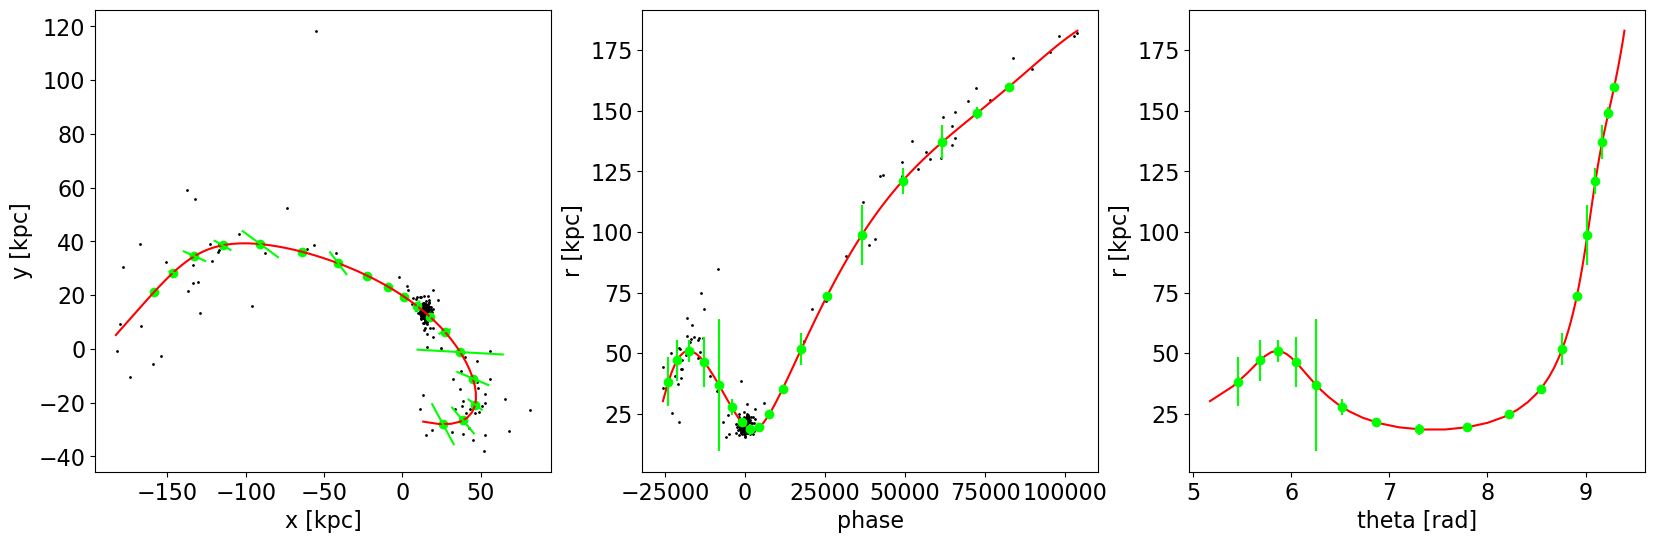

In [197]:
# Data
# params_data = np.array([12, 15, 0.9, 0.8, 8, 1, -40, 0, 0, 0, 150, 0, 2, 0.5, 0.2, 0.7])

ndim = 16
N_data = 20

d_length = 0
theta_length = 0
theta_track_data = np.array([0])
while d_length < 10 or theta_length < np.pi/2 or 5*np.pi/2 < theta_length or np.any( np.diff(theta_track_data) < 0): 
    p = np.random.uniform(0, 1, ndim)
    params_data = prior_transform(p)
    xy_stream_data, xy_track_data, gamma, gamma_track = model(params_data, N_stars=500, Nbody=False, seed=False)
    r_stream_data = np.sqrt(xy_stream_data[0]**2 + xy_stream_data[1]**2)
    r_track_data = np.sqrt(xy_track_data[0]**2 + xy_track_data[1]**2)
    theta_track_data = np.arctan2(xy_track_data[1], xy_track_data[0])
    r_track_data, theta_track_data, gamma_track = unwrap(r_track_data, theta_track_data, gamma_track)

    arc_lengths = abs(r_track_data[:-1] * np.diff(theta_track_data))
    cumulative_arc_lengths = np.concatenate([[0], np.cumsum(arc_lengths)])
    d_length     = cumulative_arc_lengths[-1]
    theta_length = abs(theta_track_data.max() - theta_track_data.min())

d = d_length/N_data  # kpc -- Desired fixed distance
fixed_distances = np.arange(d, cumulative_arc_lengths[-1]-d, d)

interp_theta = interp1d(cumulative_arc_lengths, theta_track_data, kind='cubic')
interp_gamma = interp1d(cumulative_arc_lengths, gamma_track, kind='cubic')
theta_data = interp_theta(fixed_distances)
gamma_data = interp_gamma(fixed_distances)

f = interp1d(theta_track_data, r_track_data, kind='cubic')
r_data = f(theta_data)

# dgamma  = abs(np.diff(gamma_data)[0]/2)
N_data  = []
N_pred  = []
r_sigma = []
for i in range(len(gamma_data)):
    if i == 0:
        dgamma = (gamma_data[i+1] - gamma_data[i])/2
        gamma_1, gamma_2 = gamma_data[i]-dgamma, gamma_data[i]+dgamma
        gamma_min, gamma_max = min(gamma_1, gamma_2), max(gamma_1, gamma_2)
    elif i == len(gamma_data)-1:
        dgamma = (gamma_data[i] - gamma_data[i-1])/2
        gamma_1, gamma_2 = gamma_data[i]-dgamma, gamma_data[i]+dgamma
        gamma_min, gamma_max = min(gamma_1, gamma_2), max(gamma_1, gamma_2)
    else:
        dgamma_min = (gamma_data[i] - gamma_data[i-1])/2
        dgamma_max = (gamma_data[i+1] - gamma_data[i])/2
        gamma_1, gamma_2 = gamma_data[i]-dgamma_min, gamma_data[i]+dgamma_max
        gamma_min, gamma_max = min(gamma_1, gamma_2), max(gamma_1, gamma_2)
    arg_in = np.where((gamma>gamma_min) & (gamma<gamma_max))[0]
    N_data.append(len(arg_in))
    N_pred.append(len(arg_in) * 500/10000)
    r_sigma.append(np.std(r_stream_data[arg_in]))
N_data = np.array(N_data)
N_pred = np.array(N_pred)
r_sigma = np.array(r_sigma)#/np.sqrt(N_data)

dict_data = {'theta': theta_data,
            'r': r_data,
            'r_sigma': r_sigma}

plt.figure(figsize=(20, 6))
plt.subplot(1,3,1)
plt.xlabel('x [kpc]')
plt.ylabel('y [kpc]')
plt.scatter(xy_stream_data[0], xy_stream_data[1], s=1, c='k')
plt.plot(xy_track_data[0], xy_track_data[1], c='r')
x_data = r_data*np.cos(theta_data)
y_data = r_data*np.sin(theta_data)
x_sigma = abs(r_sigma*np.cos(theta_data))
y_sigma = abs(r_sigma*np.sin(theta_data))
for i in range(len(theta_data)):
    xerr = r_sigma[i] * np.cos(theta_data[i])
    yerr = r_sigma[i] * np.sin(theta_data[i])
    plt.plot([x_data[i] - xerr, x_data[i] + xerr], [y_data[i] - yerr, y_data[i] + yerr], 'lime')
plt.scatter(x_data, y_data, c='lime')
plt.subplot(1,3,2)
plt.xlabel('phase')
plt.ylabel('r [kpc]')
plt.scatter(gamma, r_stream_data, s=1, c='k')
plt.plot(gamma_track, r_track_data, c='r')
plt.errorbar(gamma_data, r_data, yerr=r_sigma, c='lime', fmt='o')
plt.subplot(1,3,3)
plt.xlabel('theta [rad]')
plt.ylabel('r [kpc]')
plt.plot(theta_track_data, r_track_data, c='r')
plt.errorbar(theta_data, r_data, yerr=r_sigma, c='lime', fmt='o')

In [191]:
# Model
a = time.time()
# params = params_data.copy()
xy_stream, xy_track, _, _ = model(params_data, N_stars=500, Nbody=True, seed=True)
b = time.time()
print('Time to generate data:', b-a)
r_model     = np.sqrt(xy_track[0]**2 + xy_track[1]**2)
theta_model = np.arctan2(xy_track[1], xy_track[0])
r_model, theta_model, _ = unwrap(r_model, theta_model, None)

f = interp1d(theta_model, r_model, kind='cubic', bounds_error=False, fill_value=np.nan)
r_fit = f(theta_data)

BAD_VAL = -1e50
N_nan = np.isnan(r_fit).sum()
if N_nan != 0:
    logl = BAD_VAL * N_nan
else:
    logl = -0.5*np.sum( (dict_data['r'] - r_fit)**2/dict_data['r_sigma']**2 + np.log(dict_data['r_sigma']**2) )
print(logl)

Time to generate data: 0.4064362049102783
-23.999034325387548


<ErrorbarContainer object of 3 artists>

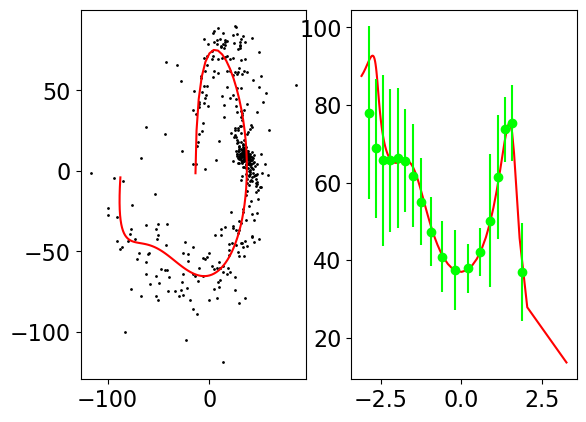

In [122]:
plt.subplot(1,2,1)
plt.scatter(xy_stream[0], xy_stream[1], s=1, c='k')
plt.plot(xy_track[0], xy_track[1], c='r')
plt.subplot(1,2,2)
plt.plot(theta_model, r_model, c='r')
plt.errorbar(theta_data, r_data, yerr=r_sigma, c='lime', fmt='o')

<ErrorbarContainer object of 3 artists>

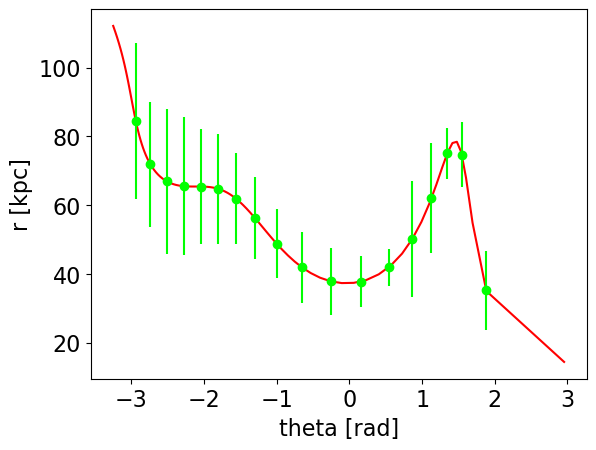

In [79]:
plt.xlabel('theta [rad]')
plt.ylabel('r [kpc]')
plt.plot(theta_track_data, r_track_data, c='r')
plt.plot(theta_data, r_fit, c='b')
plt.errorbar(theta_data, r_data, yerr=r_sigma, c='lime', fmt='o')

In [143]:
np.where( r_fit )

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),)

In [136]:
logl = -0.5*np.sum( (dict_data['r'] - r_fit)**2/dict_data['r_sigma']**2 + np.log(dict_data['r_sigma']**2) )

-9.0784529646692

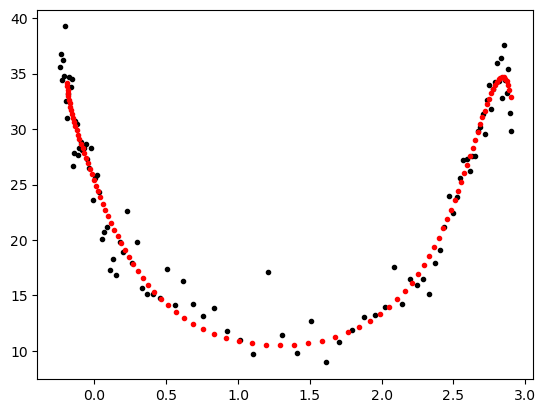

In [7]:
plt.plot(dict_data['theta'], dict_data['r'], 'k.')
plt.plot(theta_track, r_track, 'r.')

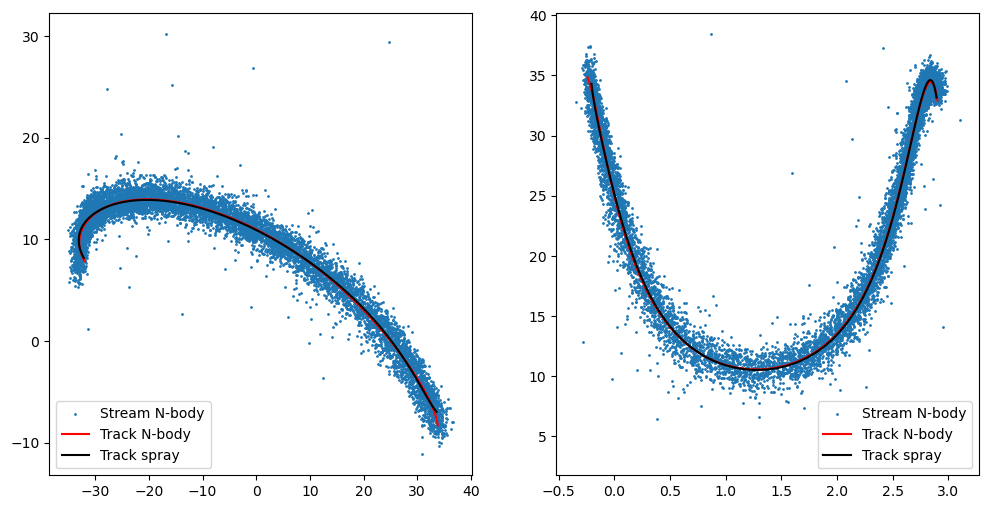

In [33]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.scatter(xy_stream_data[0], xy_stream_data[1], s=1, label='Stream N-body')
plt.plot(xy_track_data[0], xy_track_data[1], c='r', label='Track N-body')
plt.plot(xy_track[0], xy_track[1], c='k', label='Track spray')
plt.legend(loc='best')
plt.subplot(1,2,2)
r_stream_data = np.sqrt(xy_stream_data[0]**2 + xy_stream_data[1]**2)
r_track_data = np.sqrt(xy_track_data[0]**2 + xy_track_data[1]**2)
r_track = np.sqrt(xy_track[0]**2 + xy_track[1]**2)
theta_stream_data = np.arctan2(xy_stream_data[1], xy_stream_data[0])
theta_track_data = np.arctan2(xy_track_data[1], xy_track_data[0])
theta_track = np.arctan2(xy_track[1], xy_track[0])
plt.scatter(theta_stream_data, r_stream_data, s=1, label='Stream N-body')
plt.plot(theta_track_data, r_track_data, c='r', label='Track N-body')
plt.plot(theta_track, r_track, c='k', label='Track spray')
plt.legend(loc='best')

In [28]:
from scipy import interpolate

f = interpolate.interp1d(theta_track, r_track, kind='cubic', fill_value='extrapolate')
r_track_interp = f(dict_data['theta'])
logl = np.sum((dict_data['r'] - r_track_interp)**2)/dict_data['r_sigma']**2
print(logl)

93.84957999412232


In [25]:
np.arange(theta_stream_data.min()+np.pi, theta_stream_data.max(), 2*np.pi)

array([2.857399])

In [40]:
N_track  = 100
theta_stream_data = np.unwrap(np.arctan2(xy_stream_data[1], xy_stream_data[0]))
r_stream_data = np.sqrt(xy_stream_data[0]**2 + xy_stream_data[1]**2)    

arg_sort = np.argsort(theta_stream_data)
r_stream_data = r_stream_data[arg_sort]

r_spline = LSQUnivariateSpline(theta_stream_data, r_stream_data, t=np.arange(theta_stream_data.min()+np.pi, theta_stream_data.max(), 2*np.pi), k=5)

theta_fit    = np.linspace(theta_stream_data.min(), theta_stream_data.max(), N_track)
r_fit       = r_spline(theta_fit)

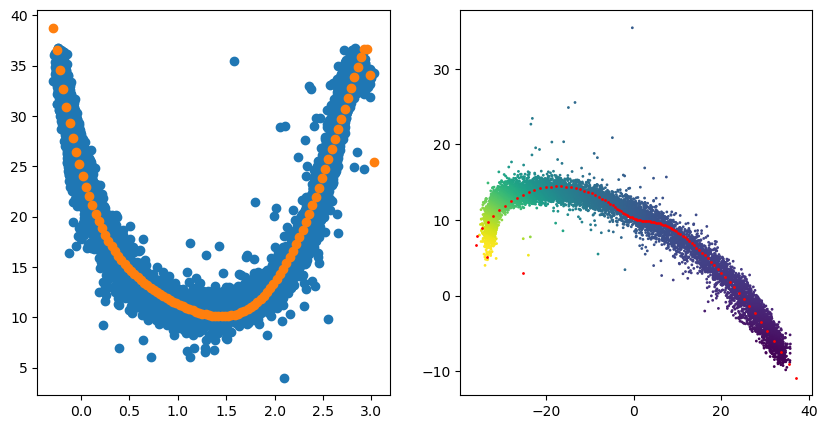

In [41]:
r_stream_data = np.sqrt(xy_stream_data[0]**2 + xy_stream_data[1]**2) 
plt.figure(figsize=(10, 5))   
plt.subplot(1, 2, 1)
plt.scatter(theta_stream_data,  r_stream_data)
plt.scatter(theta_fit, r_fit)
plt.subplot(1, 2, 2)
plt.scatter(xy_stream_data[0], xy_stream_data[1], s=1, c=gamma)
plt.scatter(r_fit*np.cos(theta_fit), r_fit*np.sin(theta_fit), s=1, c='r')

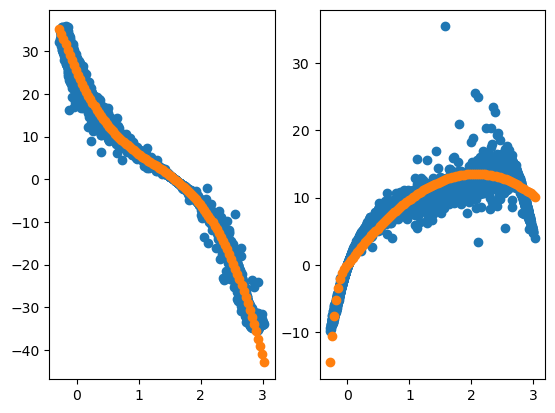

In [16]:
plt.subplot(1,2,1)
plt.scatter(theta_stream_data,  xy_stream_data[0])
plt.scatter(theta_fit, xy_track[0])
plt.subplot(1,2,2)
plt.scatter(theta_stream_data,  xy_stream_data[1])
plt.scatter(theta_fit, xy_track[1])

In [ ]:
plt.scatter(xy_track_data[0], xy_track_data[1], s=1, c='r')
plt.scatter(xy_track[0], xy_track[1], s=1, c='b')

from scipy.interpolate import LSQUnivariateSpline
N_track = 100
x_spline = LSQUnivariateSpline(gamma, xy_stream[0], t=[0], k=3, ext=0)
y_spline = LSQUnivariateSpline(gamma, xy_stream[1], t=[0], k=3, ext=0)

gamma_track = np.linspace(gamma_data.min(), gamma_data.max(), N_track)
x_fit, y_fit = x_spline(gamma_track), y_spline(gamma_track)
plt.scatter(x_fit, y_fit, s=1, c='g')

logl = np.sum( (x_fit - xy_track[0])**2 + (y_fit - xy_track[1])**2 )
plt.title(f'logL = {logl:.2f}')

In [ ]:
# Data
params_data = np.array([12, 15, 0.9, 0.8, 8, 1, -40, 0, 0, 0, 150, 0, 2, 0.5, 0.2, 0.7])
xy_stream_data, xy_track_data = model(params_data, N_stars=1000, Nbody=True, seed=False)
# xy_track_data = theta_track_fit(xy_stream_data)

# Model
ndim = 16
p    = np.random.uniform(0, 1, ndim)
params = prior_transform(p)
xy_stream, _ = model(params, N_stars=1000, Nbody=False, seed=False)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(xy_stream[0], xy_stream[1], s=1, c='b')
# plt.scatter(xy_stream_data[0], xy_stream_data[1], s=1, c='b')
plt.scatter(xy_track_data[0], xy_track_data[1], s=1, c='r')
plt.scatter(0,0, c='k', s=100)
plt.subplot(1,2,2)
r_track_data = np.sqrt(xy_track_data[0]**2 + xy_track_data[1]**2)
theta_track_data = np.arctan2(xy_track_data[1], xy_track_data[0])

r_stream = np.sqrt(xy_stream[0]**2 + xy_stream[1]**2)
theta_stream = np.arctan2(xy_stream[1], xy_stream[0])

plt.scatter(theta_stream, r_stream, s=1, c='b')
plt.scatter(theta_track_data, r_track_data, s=1, c='r')

In [ ]:
ndim = 16
min_length = 50 #kpc
max_length = 100
min_arc = np.pi/2 #rad
max_arc = 5*np.pi/2 
arret = False

while arret == False:
    p    = np.random.uniform(0, 1, ndim)
    p[2] = 0.2
    p[3] = 0.3
    params = prior_transform(p)

    xy_stream, xy_track = model(params, N_stars=1000, Nbody=False, seed=True)

    r_track = np.sqrt(xy_track[0]**2+xy_track[1]**2)
    theta_track = np.unwrap( np.arctan2(xy_track[1], xy_track[0]) )

    if (min_arc < abs(theta_track[-1] - theta_track[0]) ) & (abs(theta_track[-1] - theta_track[0]) < max_arc) & \
        (min_length < abs((r_track[:-1]*np.diff(theta_track)).sum())) & (abs((r_track[:-1]*np.diff(theta_track)).sum()) < max_length):
        arret = True

        plt.figure(figsize=(10,5))
        plt.subplot(1,2,1)
        plt.scatter(xy_stream[0], xy_stream[1], s=1, c='b')
        plt.scatter(xy_track_data[0], xy_track_data[1], s=1, c='r')
        plt.scatter(0,0, c='k', s=100)
        plt.subplot(1,2,2)
        r_track_data = np.sqrt(xy_track_data[0]**2 + xy_track_data[1]**2)
        theta_track_data = np.arctan2(xy_track_data[1], xy_track_data[0])

        r_stream = np.sqrt(xy_stream[0]**2 + xy_stream[1]**2)
        theta_stream = np.arctan2(xy_stream[1], xy_stream[0])

        plt.scatter(theta_stream, r_stream, s=1, c='b')
        plt.scatter(theta_track_data, r_track_data, s=1, c='r')
        
